In [161]:
import numpy as np
import scipy
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from numerical_eqs.pde.utils import tridiag_mult, gen_mats

from numerical_eqs.ode.sdole import SDOLESolve

In [162]:
def SDOLEPDESolver(
    mesh,
    u0,
    t0,
    t1,
    func,
    
    progress = True,
    
    # Boundary conditions on the end of each interval
    boundaries = (None, None),
    
    # Look in SDOLESolver and enter kwargs as dict here
    ode_args = {}
):
    '''Solves generic PDE, using Step DOubling and Local Extrapolation
    ''' 
    
    # Make our boundaries default to +0 von neumann
    boundaries = list(map(
        lambda x: {'type': 'neumann', 'f': lambda t: 0.0} if x is None else x,
        boundaries
    ))
    
   
    # # Now run our ODE solver
    res = SDOLESolve(
        y0 = u0,
        func = func,
        t0 = t0,
        t1 = t1,
        progress = progress,
        # This is important
        # Our step function will do the full deal on its own
        dont_wrap_func=True,
        **ode_args
    )
    
    
    # pass along results
    return res





class FisherEQSolver:
    eps = 1e-8
    def __init__(self, mesh, boundaries, d_func, e_func, f_func,
                 err_fn = lambda x: np.linalg.norm(x, ord=np.inf),
                 theta = 1,
                ):
        '''Install all the extra bits we'll need to evaluate dU
        '''
        self.boundaries = boundaries
        self.mesh = mesh
        self.d = d_func
        self.e = e_func
        self.f = f_func
        self.errfn = err_fn
        self.theta = theta
        
        # Generate Matrices
        self.M, self.S = gen_mats(
            # M base
            np.asarray([
                [1/3, 1/6],
                [1/6, 1/3]
            ]),
            # S base
            np.asarray([
                [1,-1],
                [-1, 1]
            ]),
            # Our mesh evaluation points
            self.mesh,
            # Dimension functions
            self.d,
            self.e,
        )
        
        # Precompute some stuff for speed
        self.dx = mesh[1:] - mesh[:-1]
        self.xmid = (mesh[1:] + mesh[:-1])/2
        
        
    
    def _handle_f (self, U, t, dt):
        '''evaluate F and numerically generate F and tridiagonal DF on the mesh
        '''
        n = U.size
        
        F = np.zeros(n)
        DF = np.zeros((3, n))
        
        umid = (U[:-1] + U[1:])/2
        
        # Evaluation
        fmid = self.f(self.xmid, umid)
        
        # Estimate derivative numerically
        if isinstance(fmid, tuple) and len(fmid) == 2:
            fmid, dfdu = fmid
        else:
             dfdu = (
                self.f(self.xmid, umid + self.eps) -
                self.f(self.xmid, umid - self.eps)
            ) / (2*self.eps)
        
        fmid = np.broadcast_to(fmid, self.dx.shape)
        dfdu = np.broadcast_to(dfdu, self.dx.shape)

        # Precompute these arrays
        a = fmid * self.dx/2
        b = dfdu * self.dx/4
        
        # Now sum them into the right places
        F[1:]  += a
        F[:-1] += a
        DF[1, :-1] += b
        DF[1, 1:]  += b
        DF[0, 1:]  += b
        DF[2, :-1] += b
    
        # Throw it back    
        return F, DF
        
        
        
    
    
    def _step_dU_raw (self, U, t, dt):
        '''Actually evaluate dU at a given instance
        '''
        F, DF = self._handle_f(U, t, dt)

        Q = self.M / dt + self.theta * (self.S - DF)
        R = F - tridiag_mult(self.S,U)
        
        for i, b in zip((0,-1), self.boundaries):
            # Set the delta numerically, so that dU + U is known (=g(t)) for t+dt
            if b.get('type') == 'dirichlet':
                
                R[i] = b.get('f')(t) - U[i]
                Q[i, 1+3*i] = 0

            # Just add in the flux on the particular side
            elif b.get('type') == 'neumann':
                R[i] += b.get('f')(t)

        
        dU = scipy.linalg.solve_banded(
            (1,1),
            Q, R,
            overwrite_ab = True,
            overwrite_b = True
        )
        
        return dU

    
    
    
    def _step_dU(self, U, t, dt):
        '''Evaluates both the step dU and the nonlinear error associated with this step
        Note: makes 3 primitive dU evaluations
        '''
        D1 = self._step_dU_raw( U, t, dt ) + U

        U1 = self._step_dU_raw( U, t, dt*0.5) + U
        D2 = self._step_dU_raw( U1, t+dt*0.5, dt*0.5) + U1

        Ut = 2*D2 - D1
        err = self.errfn( D2 - D1 )

        return Ut, err
    
    
    
        
    def __call__(self, x, t, dt):
        '''This will do a lot in the background, and should return the dU desired
        from here, the ODE solver can generate the rest
        '''    
        return self._step_dU(x, t, dt)


## My code is large and looks horrible, but I'm OK with that

I'm taking the code I wrote in this class and combining it with stuff from the numerical ODE class and packaging it together so I can use in the future. I expanded some functionality in an SDOLE ODE solver that sits in the ODE folder. I also added the ability to solve for specific points on the interior of the time solution set, by solving subintervals recursively. For this I also needed to slightly modify SimTime, so it can track what a good estimate dt would be, and this is passed on to the next recursive run.

Files that contain code for this specific project:
* mainly this file
* pde.py has a little, under numerical_eqs/pde/...
* the ODE solver, in the file numerical_eqs/ode/sdole.py
* the SimTime object, in numerical_eqs/utils/simtime.py

100%|██████████| 4.0/4 [00:00<00:00, 26.54it/s]             

Case 0


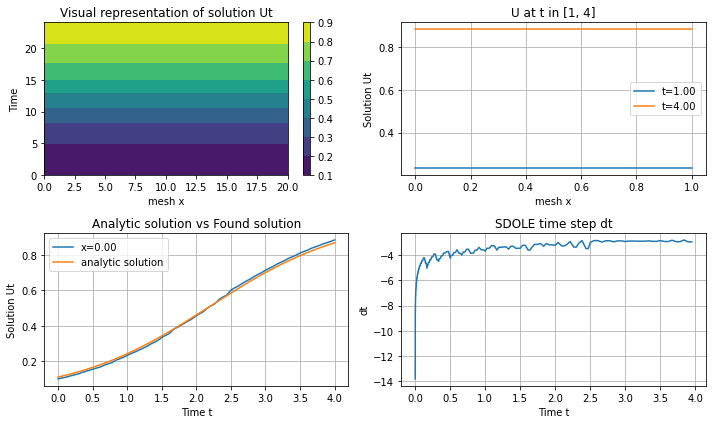

In [163]:
print("Case 0")

meshsize = 20
mesh = []
l = lambda x: x + 0.75*x*(1-x)
for i in range(meshsize+1):
    mesh.append( l(i/20) )
mesh = np.asarray(mesh)
# print(mesh)
# return
u0 = 0.1 * np.ones(mesh.shape)
t0, t1 = (0, 4)

boundaries = (
    {'type': 'neumann', 'f': lambda t: 0},
    {'type': 'neumann', 'f': lambda t: 0},
)
d_func = lambda x: 1.0
e_func = lambda x: 1.0

time_points = [1, 4]
plot_points = np.linspace(t0, t1, 25)
explicit_times = {
    'time points': time_points + plot_points.tolist(),
}

def f_func(x, u):
    f_eval = np.maximum(u*(1-u), 0)
    df = np.where( u*(1-u) > 0, 1-2*u, 0 )
    return f_eval


res = SDOLEPDESolver(
    mesh = mesh,
    u0 = u0,
    t0 = t0,
    t1 = t1,
    # Use the fisher equation solver we built
    #  It'll call the __call__()
    func = FisherEQSolver(
        mesh = mesh,
        boundaries = boundaries,
        d_func = d_func,
        e_func = e_func,
        f_func = f_func,
    ),
    
    # Show the progress bar
    progress = True,
    
    ode_args = {
        'explicit_times': explicit_times,
    }
)

sol_y = res['ys']
sol_t = res['time']






k = 4
cols = 2
rows = k//cols
fig, axs = plt.subplots(rows, cols, figsize=(5*cols,3*rows))
axs = np.asarray(axs).flatten()


j = np.zeros(sol_t.shape)
for t in plot_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.nonzero( j )
# Plot this using the colorbar
cf = axs[0].contourf(
    sol_y[times, :][0,:,:]
)
fig.colorbar(cf, ax=axs[0])
axs[0].set_title('Visual representation of solution Ut')
axs[0].set_xlabel('mesh x')
axs[0].set_ylabel('Time')





j = np.zeros(sol_t.shape)
for t in time_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.asarray(np.nonzero( j )).flatten()

for i, t in zip(times, time_points):
    axs[1].plot(
        mesh,
        sol_y[i,:],
        label='t={0:.2f}'.format(t)
    )

axs[1].set_title('U at t in {0}'.format(time_points))
axs[1].set_xlabel('mesh x')
axs[1].set_ylabel('Solution Ut')
axs[1].legend()
axs[1].grid()





analytic_sol = lambda t: 0.01 + np.exp(t)/(9+np.exp(t))
for i in [0]:
    axs[2].plot(
        sol_t,
        sol_y[:,i],
        label='x={0:.2f}'.format(mesh[i])
    )
axs[2].plot(
    sol_t,
    analytic_sol(sol_t),
    label='analytic solution'
)
axs[2].set_title('Analytic solution vs Found solution')
axs[2].set_xlabel('Time t')
axs[2].set_ylabel('Solution Ut')
axs[2].legend()
axs[2].grid()



axs[3].plot(
    sol_t[:-1],
    np.log(sol_t[1:] - sol_t[:-1]),
)
axs[3].set_title('SDOLE time step dt')
axs[3].set_xlabel('Time t')
axs[3].set_ylabel('dt')
axs[3].grid()

fig.tight_layout()
plt.show()

None

  0%|          | 0.017740370367472762/12 [00:00<01:07,  5.65s/it]

Case 1


100%|██████████| 12.0/12 [00:00<00:00, 39.33it/s]                


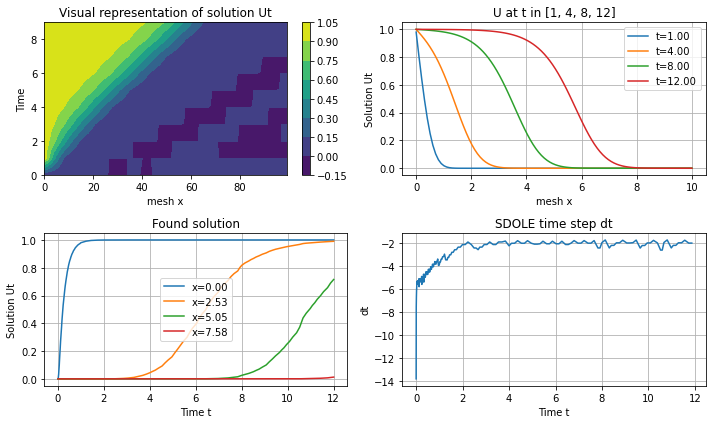

In [166]:
print("Case 1")

meshsize = 100
mesh = np.linspace(0, 10, meshsize)
u0 = np.zeros(mesh.shape)
t0, t1 = (0, 12)

boundaries = (
    {'type': 'dirichlet', 'f': lambda t: (np.exp(4*t) - 1) / np.exp(4*t)},
    {'type': 'neumann', 'f': lambda t: 0},
)
d_func = lambda x: 1.0
e_func = lambda x: 0.1

time_points = [1, 4, 8, 12]
plot_points = np.linspace(t0, t1, 10)
explicit_times = {
    'time points': time_points + plot_points.tolist(),
}

# Re-use f_func from above

res = SDOLEPDESolver(
    mesh = mesh,
    u0 = u0,
    t0 = t0,
    t1 = t1,
    # Use the fisher equation solver we built
    #  It'll call the __call__()
    func = FisherEQSolver(
        mesh = mesh,
        boundaries = boundaries,
        d_func = d_func,
        e_func = e_func,
        f_func = f_func,
    ),
    
    # Show the progress bar
    progress = True,
    
    ode_args = {
        'explicit_times': explicit_times,
    }
)

sol_y = res['ys']
sol_t = res['time']






k = 3
cols = 2
rows = int(np.ceil(k / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5*cols,3*rows))
axs = np.asarray(axs).flatten()


j = np.zeros(sol_t.shape)
for t in plot_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.nonzero( j )
# Plot this using the colorbar
cf = axs[0].contourf(
    sol_y[times, :][0,:,:]
)
fig.colorbar(cf, ax=axs[0])
axs[0].set_title('Visual representation of solution Ut')
axs[0].set_xlabel('mesh x')
axs[0].set_ylabel('Time')





j = np.zeros(sol_t.shape)
for t in time_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.asarray(np.nonzero( j )).flatten()

for i, t in zip(times, time_points):
    axs[1].plot(
        mesh,
        sol_y[i,:],
        label='t={0:.2f}'.format(t)
    )

axs[1].set_title('U at t in {0}'.format(time_points))
axs[1].set_xlabel('mesh x')
axs[1].set_ylabel('Solution Ut')
axs[1].legend()
axs[1].grid()





for i in range(0, len(mesh), 25):
    axs[2].plot(
        sol_t,
        sol_y[:,i],
        label='x={0:.2f}'.format(mesh[i])
    )
axs[2].set_title('Found solution')
axs[2].set_xlabel('Time t')
axs[2].set_ylabel('Solution Ut')
axs[2].legend()
axs[2].grid()



axs[3].plot(
    sol_t[:-1],
    np.log(sol_t[1:] - sol_t[:-1]),
)
axs[3].set_title('SDOLE time step dt')
axs[3].set_xlabel('Time t')
axs[3].set_ylabel('dt')
axs[3].grid()

fig.tight_layout()
plt.show()

None

  2%|▏         | 0.18894880166869277/12 [00:00<00:06,  1.88it/s]

Case 2


100%|██████████| 12.0/12 [00:00<00:00, 44.03it/s]               


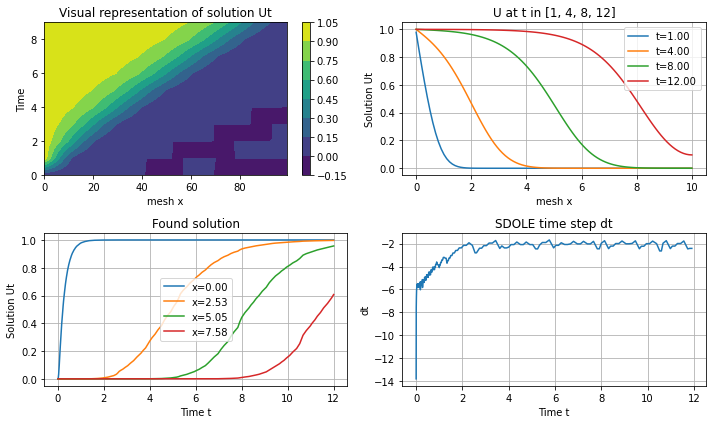

In [167]:
print("Case 2")

# meshsize = 100
# mesh = np.linspace(0, 10, meshsize)
# u0 = np.zeros(mesh.shape)
# t0, t1 = (0, 12)

# boundaries = (
#     {'type': 'dirichlet', 'f': lambda t: (np.exp(4*t) - 1) / np.exp(4*t)},
#     {'type': 'neumann', 'f': lambda t: 0},
# )
d_func = lambda x: 1.0
e_func = lambda x: 0.2

# time_points = [1, 4, 8, 12]
# plot_points = np.linspace(t0, t1, 10)
# explicit_times = {
#     'time points': time_points + plot_points.tolist(),
# }

# Re-use f_func from above

res = SDOLEPDESolver(
    mesh = mesh,
    u0 = u0,
    t0 = t0,
    t1 = t1,
    # Use the fisher equation solver we built
    #  It'll call the __call__()
    func = FisherEQSolver(
        mesh = mesh,
        boundaries = boundaries,
        d_func = d_func,
        e_func = e_func,
        f_func = f_func,
    ),
    
    # Show the progress bar
    progress = True,
    
    ode_args = {
        'explicit_times': explicit_times,
    }
)

sol_y = res['ys']
sol_t = res['time']






k = 3
cols = 2
rows = int(np.ceil(k / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5*cols,3*rows))
axs = np.asarray(axs).flatten()


j = np.zeros(sol_t.shape)
for t in plot_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.nonzero( j )
# Plot this using the colorbar
cf = axs[0].contourf(
    sol_y[times, :][0,:,:]
)
fig.colorbar(cf, ax=axs[0])
axs[0].set_title('Visual representation of solution Ut')
axs[0].set_xlabel('mesh x')
axs[0].set_ylabel('Time')





j = np.zeros(sol_t.shape)
for t in time_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.asarray(np.nonzero( j )).flatten()

for i, t in zip(times, time_points):
    axs[1].plot(
        mesh,
        sol_y[i,:],
        label='t={0:.2f}'.format(t)
    )

axs[1].set_title('U at t in {0}'.format(time_points))
axs[1].set_xlabel('mesh x')
axs[1].set_ylabel('Solution Ut')
axs[1].legend()
axs[1].grid()





for i in range(0, len(mesh), 25):
    axs[2].plot(
        sol_t,
        sol_y[:,i],
        label='x={0:.2f}'.format(mesh[i])
    )
axs[2].set_title('Found solution')
axs[2].set_xlabel('Time t')
axs[2].set_ylabel('Solution Ut')
axs[2].legend()
axs[2].grid()



axs[3].plot(
    sol_t[:-1],
    np.log(sol_t[1:] - sol_t[:-1]),
)
axs[3].set_title('SDOLE time step dt')
axs[3].set_xlabel('Time t')
axs[3].set_ylabel('dt')
axs[3].grid()

fig.tight_layout()
plt.show()

None